# Reproduction of kaggle first place

Based on:

https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266385

https://www.kaggle.com/code/ligtfeather/eca-nfnet-sam-opt-mixup-k-folds-w-b

First place solution architecture:

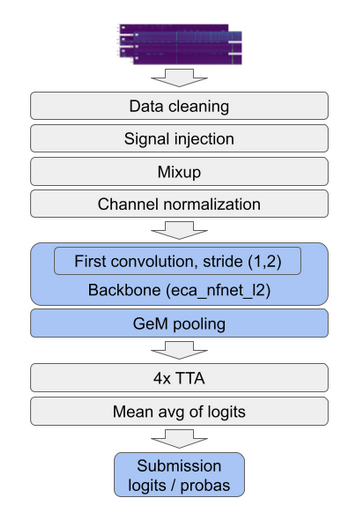

In [1]:
# !pip install timm
# !pip install albumentations
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install torchsummary

In [2]:
import os
import random
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary

import torchvision.transforms as transforms
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
import timm
from adamp import AdamP

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import wandb
from matplotlib import pyplot as plt

In [3]:
config = {
    'num_workers': 4,
    'model': 'eca_nfnet_l0',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'batch_size': 50,
    'epochs': 10,
    'num_folds': 3
}

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(seed=config['seed'])

# Data Loading

In [5]:
train_data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_filepath = os.path.join(train_data_dir, '500_balanced_labels.npy')

with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)
    
initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

In [6]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1000 non-null   string
 1   target          1000 non-null   int32 
 2   image_filepath  1000 non-null   string
dtypes: int32(1), string(2)
memory usage: 19.7 KB


Split the data into 70% train and 30% test:

In [39]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

# Custom Dataset

In [8]:
def resize_image(image):
    # img = cv2.imread('your_image.jpg')
    return cv2.resize(image, dsize=(config['image_size'], config['image_size']), interpolation=cv2.INTER_CUBIC)

def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()

In [9]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform
        # self.transform = None

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = np.load(image_filepath).astype(np.float32)
        # min max normalise (between 0 and 1)
        image = np.vstack(image).transpose((1, 0)) # stacks all 6 images vertically and then rotates 90 degrees
            
        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        label = torch.tensor(self.targets[idx]).float()

        return image, label

# Image Augmentation

In [10]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'], config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(brightness_limit=0.6, p=0.5),
            albumentations.CoarseDropout(max_holes=10, max_height=12, max_width=12, fill_value=0),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'],config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(config['image_size'], config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

## Mixup

In [11]:
def mixup(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Loss and ROC Monitoring

In [12]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    
def use_roc_score(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()

        return roc_auc_score(target, y_pred)
    except:
        return 0.5

# Weight Random Sampler

In [13]:
def get_sampler(train_data):
    class_counts = train_data['target'].value_counts().to_list()
    num_samples = sum(class_counts)
    labels = train_data['target'].to_list()

    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]

    return WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# Train and Validation Dataloaders

In [14]:
def get_loaders(train_data, valid_data, sampler):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        transform=get_train_transforms()
    )

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        transform=get_valid_transforms()
    )

    train_loader = DataLoader(
        training_set,
        batch_size=config['batch_size'],
        # shuffle=True,
        # num_workers=config['num_workers'],
        sampler = sampler,
        pin_memory=True
    )

    valid_loader = DataLoader(
        validation_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return train_loader, valid_loader

# Model

In [15]:
class EcaNFNet(nn.Module):
    def __init__(self, model_name=config['model'], output_features=config['output_features'],
                 input_channels=config['input_channels'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                       in_chans=input_channels)

        # change first convolutional layer to have stride (1,2)


        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, output_features, bias=True)    
    
    def forward(self, x):
        x = self.model(x)
        return x

# Sharpness Aware Minimisation (SAM) Optimiser

In [16]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

# Initialise Model, Loss Function, Optimizer and Scheduler

In [17]:
model = EcaNFNet()
model = model.to(config['device'])
criterion = nn.BCEWithLogitsLoss().to(config['device'])
base_optimizer = AdamP
optimizer = SAM(model.parameters(), base_optimizer, lr=config['lr'], weight_decay=config['weight_decay'])

scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['T_max'],
                              eta_min=config['min_lr'],
                              last_epoch=-1)

In [18]:
summary(model.cuda(), (1, 1344, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ScaledStdConv2d-1         [-1, 16, 672, 112]             160
              SiLU-2         [-1, 16, 672, 112]               0
   ScaledStdConv2d-3         [-1, 32, 672, 112]           4,640
              SiLU-4         [-1, 32, 672, 112]               0
   ScaledStdConv2d-5         [-1, 64, 672, 112]          18,496
              SiLU-6         [-1, 64, 672, 112]               0
   ScaledStdConv2d-7         [-1, 128, 336, 56]          73,856
              SiLU-8         [-1, 128, 336, 56]               0
          Identity-9         [-1, 128, 336, 56]               0
  ScaledStdConv2d-10         [-1, 256, 336, 56]          33,024
    DownsampleAvg-11         [-1, 256, 336, 56]               0
  ScaledStdConv2d-12          [-1, 64, 336, 56]           8,256
             SiLU-13          [-1, 64, 336, 56]               0
  ScaledStdConv2d-14          [-1, 64, 

# K-Fold CV

In [19]:
def train(train_loader, model, criterion, optimizer, epoch, scheduler):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(enumerate(train_loader), total=len(train_loader))
       
    for i, (images, target) in stream:
        images = images.to(config['device'])
        target = target.to(config['device']).float().view(-1, 1)
        images, targets_a, targets_b, lam = mixup(images, target.view(-1, 1))

        optimizer.zero_grad()

        output = model(images)

        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward(retain_graph=True)

        optimizer.first_step(zero_grad=False)
        optimizer.zero_grad()
        
        mixup_criterion(criterion, model(images), targets_a, targets_b, lam).backward()
        optimizer.second_step(zero_grad=False)
        
        roc_score = use_roc_score(output, target)

        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('ROC', roc_score)

        wandb.log({'Train Epoch': epoch, 'Train loss': loss.item(), 'Train ROC': roc_score})

        stream.set_description('Epoch: {epoch}. Train. {metric_monitor}'
                               .format(epoch=epoch, metric_monitor=metric_monitor))

    scheduler.step()

In [20]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(enumerate(val_loader), total=len(val_loader))
    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for i, (images, target) in stream:
            images = images.to(config['device'], non_blocking=True)
            target = target.to(config['device'], non_blocking=True).float().view(-1, 1)

            output = model(images)
            loss = criterion(output, target)
            roc_score = use_roc_score(output, target)

            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC', roc_score)

            wandb.log({"Valid Epoch": epoch, "Valid loss": loss.item(), "Valid ROC":roc_score})

            stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}"
                                   .format(epoch=epoch, metric_monitor=metric_monitor))
            
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)

    return final_outputs, final_targets

# W&B Initialisation for K-Fold CV

**W&B API key**: 47b00b0f6291346fe94ab4a6dceca03a809fbf4a

# Training loop

Create directory to save models for this run:

In [21]:
current_datetime = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
models_dir = os.path.join('models', current_datetime)
os.mkdir(models_dir)

Execute the training loop:

In [22]:
best_roc = -np.inf
best_epoch = -np.inf
best_model_name = None
kfold = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed'])

for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_df, train_df['target'])):
    run = wandb.init(
            project='eca-NFNet-Mixup',
            config=config,
            group='ECA-NFNet',
            job_type='train',
            name=f"{current_datetime} - fold {fold}")

    print(f"{'='*40} Fold: {fold} {'='*40}")

    train_data = train_df.iloc[trn_idx]
    valid_data = train_df.iloc[val_idx]

    sampler = get_sampler(train_data)

    train_loader, valid_loader = get_loaders(train_data, valid_data, sampler)

    for epoch in range(1, config['epochs'] + 1):
        train(train_loader, model, criterion, optimizer, epoch, scheduler)
        valid_predictions, valid_targets = validate(valid_loader, model, criterion, epoch)

        valid_roc_auc = round(roc_auc_score(valid_targets, valid_predictions), 3)

        torch.save(model.state_dict(), os.path.join(models_dir, f"{config['model']}_{epoch}_epoch_{valid_roc_auc}_roc_auc.pth"))

        if valid_roc_auc > best_roc:
            best_roc = valid_roc_auc
            best_epoch = epoch
            best_model_name = f"{config['model']}_{epoch}_epoch_{valid_roc_auc}_roc_auc.pth"

    print(f'Best ROC-AUC in fold {fold} was {best_roc:.4f}')
    print(f'Final ROC-AUC in fold {fold} was {valid_roc_auc:.4f}')
    print(f'Best model name in fold {fold} was {best_model_name}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mllm. Use `wandb login --relogin` to force relogin


======================================== Fold: 0 ========================================


Epoch: 1. Train. Loss: 0.694 | ROC: 0.481: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]
D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\venv\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch: 1. Validation. Loss: 0.693 | ROC: 0.478: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
Epoch: 2. Train. Loss: 0.694 | ROC: 0.509: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]
Epoch: 2. Validation. Loss: 0.696 | ROC: 0.497: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
Epoch: 3. Train. Loss: 0.672 

Best ROC-AUC in fold 0 was 0.5300
Final ROC-AUC in fold 0 was 0.4890
Best model name in fold 0 was eca_nfnet_l0_4_epoch_0.53_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
Train ROC,▆▄▃▂█▇▃▂▅▃▄▃▅▆▄▃▃▄▂▅▃▅▄█▂▄▄▂▆▆▁▄▆▇▅▅▁▆▄▅
Train loss,▅▆▆▆▅▆▆▇▆▂▁▂▄▆▆▃▆▄▆▆▆▆█▇▅▆▅▆▅██▇▃▆▆█▆▇▇▃
Valid Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
Valid ROC,▅▅▂▅▅▅▅▅▅▅▂▅▅▅█▅▅▅▄▅▅▅▁▅▅▅▃▅▅▅▄▅▅▅▄▅▅▅▄▅
Valid loss,▅▄▄▃▄▄▄▄██▃▁▄▄▄▄▄▄▄▃▆▅▄▃▅▅▄▃▅▄▄▃▄▄▄▃▄▄▄▃
Train Epoch,10
Train ROC,0.53704
Train loss,0.66836
Valid Epoch,10
Valid ROC,0.5


======================================== Fold: 1 ========================================


Epoch: 1. Train. Loss: 0.685 | ROC: 0.547: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]
Epoch: 1. Validation. Loss: 0.679 | ROC: 0.513: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
Epoch: 2. Train. Loss: 0.696 | ROC: 0.522: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]
Epoch: 2. Validation. Loss: 0.679 | ROC: 0.513: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
Epoch: 3. Train. Loss: 0.692 | ROC: 0.568: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]
Epoch: 3. Validation. Loss: 0.682 | ROC: 0.520: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
Epoch: 4. Train. Loss: 0.690 | ROC: 0.511: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]
Epoch: 4. Validation. Loss: 0.684 | ROC: 0.529: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
Epoch: 5. Train. Loss: 0.690 | ROC: 0.483: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]
Epoch: 5. Validation. Loss: 0.682 | ROC: 0.532: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
Epoch: 6. Train. Loss: 0.688 | ROC: 0.554: 100%|██████████| 10/10 [00:22<00

Best ROC-AUC in fold 1 was 0.5720
Final ROC-AUC in fold 1 was 0.4060
Best model name in fold 1 was eca_nfnet_l0_3_epoch_0.572_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
Train ROC,▅▆▇▅▆▅▆▄▅▆█▅▁▆▅▇█▂▄▆▇▆▇▆▅█▅▄▇█▇▅▅▅▇▇▇▇▆▄
Train loss,▅▇▃▅▆▄▄▇▄▆▅▆▄▅▅▅▅▇▄▄▃▇▃▆▄▃▆▆▁▅▅▃▅▆▅▅▃▃▂█
Valid Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
Valid ROC,▁▁▄▁▁▁▄▁▁▁▅▁▁▁▇▁▁▁█▁▁▁▇▁▁▁▄▁▁▁▃▁▁▁▅▁▁▁▅▁
Valid loss,▄▄▃▃▄▄▃▃▃▃▃▃▃▃▃▃▄▄▃▃▄▃▃▃▅▅▃▂▄▄▃▃▃▄▃▃▇█▃▁
Train Epoch,10
Train ROC,0.44872
Train loss,0.71381
Valid Epoch,10
Valid ROC,0.5


======================================== Fold: 2 ========================================


Epoch: 1. Train. Loss: 0.701 | ROC: 0.524: 100%|██████████| 10/10 [01:35<00:00,  9.54s/it]
Epoch: 1. Validation. Loss: 0.686 | ROC: 0.530: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
Epoch: 2. Train. Loss: 0.692 | ROC: 0.468: 100%|██████████| 10/10 [01:18<00:00,  7.84s/it]
Epoch: 2. Validation. Loss: 0.687 | ROC: 0.528: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
Epoch: 3. Train. Loss: 0.688 | ROC: 0.513: 100%|██████████| 10/10 [01:18<00:00,  7.80s/it]
Epoch: 3. Validation. Loss: 0.685 | ROC: 0.512: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]
Epoch: 4. Train. Loss: 0.689 | ROC: 0.511: 100%|██████████| 10/10 [01:18<00:00,  7.81s/it]
Epoch: 4. Validation. Loss: 0.686 | ROC: 0.510: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
Epoch: 5. Train. Loss: 0.687 | ROC: 0.564: 100%|██████████| 10/10 [01:18<00:00,  7.84s/it]
Epoch: 5. Validation. Loss: 0.693 | ROC: 0.506: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
Epoch: 6. Train. Loss: 0.684 | ROC: 0.563: 100%|██████████| 10/10 [01:18<00

Best ROC-AUC in fold 2 was 0.5910
Final ROC-AUC in fold 2 was 0.5410
Best model name in fold 2 was eca_nfnet_l0_1_epoch_0.591_roc_auc.pth


# Analysis

## Run best performing model against test set

In [36]:
def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_data['target'].values,
        # transform=get_valid_transforms()
    )

    return DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return test_loader

In [37]:
def test_model(model_path):
    final_targets = []
    final_outputs = []

    model = EcaNFNet()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    metric_monitor = MetricMonitor()
    test_loader = get_test_loader(test_df)
    stream = tqdm(enumerate(test_loader), total=len(test_loader))

    with torch.no_grad():
        for i, (images, target) in stream:
            images = images.to('cpu', non_blocking=True)
            target = target.to('cpu', non_blocking=True).float().view(-1, 1)

            output = model(images)
            loss = criterion(output, target)
            roc_score = use_roc_score(output, target)

            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC', roc_score)

            wandb.log({'Test loss': loss.item(), ' Test ROC': roc_score})

            stream.set_description('Test. {metric_monitor}'.format(metric_monitor=metric_monitor))

            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(outputs)

    return final_outputs, final_targets

In [42]:
test_outputs, test_targets = test_model(os.path.join(models_dir, 'eca_nfnet_l0_1_epoch_0.591_roc_auc.pth'))

Test. Loss: 0.690 | ROC: 0.522: 100%|██████████| 6/6 [01:24<00:00, 14.06s/it]


In [43]:
test_results_df = pd.DataFrame([test_targets, test_outputs])
test_results_df = test_results_df.transpose()
test_results_df.columns = ['label', 'prediction']

test_results_df['label'] = test_results_df['label'].apply(lambda x: x[0])
test_results_df['prediction'] = test_results_df['prediction'].apply(lambda x: x[0])

# Use threshold of > 0.5 for a positive prediction, else it is a negative prediction
test_results_df['prediction'] = test_results_df['prediction'].apply(lambda x: 1.0 if x > 0.5 else 0)

In [44]:
pd.crosstab(test_results_df['prediction'], test_results_df['label'])

label,0.0,1.0
prediction,,
0,149,149


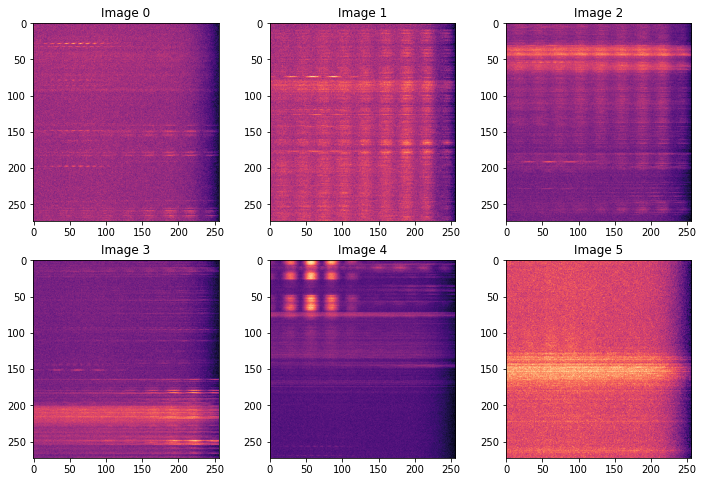

In [60]:
# initial_data_df.head()
# initial_data_df[~data_split_mask].head()

sample_images = np.load(test_df.iloc[294].image_filepath).astype(np.float32)

f, ax = plt.subplots(2,3, figsize=(12,8))

for i in range(len(sample_images)):
    row = i // 3
    column = i - row * 3

    ax[row, column].set_title('Image ' + str(i))
    ax[row, column].imshow(sample_images[i], cmap=plt.get_cmap('magma'))